# Parcels run African Shelf
- 4 releases per year release;
- loaction: African shelf <500m depth
- release in layer 1-5 
- no mortality in parcels run, done in analysis part
- output dt: 24h

In [2]:
from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
)
import os
from operator import attrgetter
from pathlib import Path
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
import parcels
from shapely.geometry import Polygon, Point
import cartopy
import matplotlib.pyplot as plt
from lib.release_zones import (
    csv_to_polygons_lon_lat,
    get_uniform_random_latlon_in,
    get_uniform_random_latlon_close_to_polygon,
    get_uniform_random_latlon_within_polygon,
)
print(parcels.version)

2.3.1


In [4]:
# parameters
RNG_seed = 12345
number_particles=50000

# release box parameters
release_depth_layer_index = 0
release_layer_num = 4


# release timing
release_time_in_days = 1
start_year = 2008 
start_week = 1

# experiment duration 
runtime_in_days = 180 
dt_in_minutes =  3*60

#output
outputdt_in_hours =  24 
timearrow = 1
alt_release = False

#2nd gen specific 
second_gen = True
release_zone_nr = 4 #from 1 to 4 from north to south along shelf
#scales particle number dowm by a factor determined by the area of the release box, so that over all 4 regions the particles are equally distributed
scale_part_number = True 

## Create fieldset

In [5]:
np.random.seed(RNG_seed)

def find_i_j(lon, lat, LON, LAT):
    '''  get indices of (lon, lat) point on NEMO grid (LON,LAT)
         lon, lat: Point to get the indice
         LON, LAT: NEMO nav_lon, nav_lat '''
    a = abs(LAT - lat) + abs(LON - lon)
    j, i = np.unravel_index(a.argmin(), a.shape)
    return (i, j)

#load input data
mask_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/")
mesh_mask_filename = '1_mesh_mask.nc'

mesh_mask = mask_path / mesh_mask_filename

mesh_hgr = xr.open_dataset(mesh_mask)
mesh_hgr = mesh_hgr.squeeze()
glon = mesh_hgr.glamt 
glat = mesh_hgr.gphit

#window
lattop=40
latbottom=-20
lonleft=-50
lonright=15

i_left, j_bottom = find_i_j(lonleft, latbottom, glon, glat)
i_right, j_top = find_i_j(lonright, lattop, glon, glat)


sd_i1, sd_i2 = i_left, i_right  # western/eastern limit (indices not coordinates)
sd_j1, sd_j2 = j_bottom, j_top  # southern/northern limit (indices not coordinates)

sd_z1, sd_z2 = 0 , 14 #vertical limits indices (first 160 m , 15 levels)
                       

x_window=slice(i_left, i_right)
y_window=slice(j_bottom, j_top)

mesh_mask = mask_path / mesh_mask_filename

#input data filename
experiment_name = "VIKING20X.L46-KFS003"
data_resolution = "1d"

data_path = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/"
data_path_w = "/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/derived/1d_compressed"

years_run = np.arange(int(runtime_in_days / 365)) + start_year # all years needed for run

if timearrow == -1:
    years_run = np.sort(-np.arange(int(runtime_in_days / 365)) + start_year)# all years needed for run
    
    files_U_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_U.nc'))
    files_V_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_V.nc'))
    files_W_list = list(Path(data_path_w).glob(f'1_{experiment_name}_{data_resolution}_{start_year - len(years_run)+1}*_grid_W.nc'))

else:

    files_U_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_U.nc'))
    files_V_list = list(Path(data_path).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_V.nc'))
    files_W_list = list(Path(data_path_w).glob(f'1_{experiment_name}_{data_resolution}_{start_year}*_grid_W.nc'))


#for multiple consecutive years after stating year
for year in years_run[1:]:
    file_U = f'1_{experiment_name}_{data_resolution}_{year}*_grid_U.nc'
    file_V = f'1_{experiment_name}_{data_resolution}_{year}*_grid_V.nc' 
    file_W = f'1_{experiment_name}_{data_resolution}_{year}*_grid_W.nc' 
    
    files_U_list.append(list(Path(data_path).glob(file_U))[0])
    files_V_list.append(list(Path(data_path).glob(file_V))[0]) 
    files_W_list.append(list(Path(data_path_w).glob(file_W))[0])
    #T_list

#choose release depths from layers of VIKING grid 
layer_depths = mesh_hgr.nav_lev[:10].values #upper 10 layers
depth_min = layer_depths[release_depth_layer_index]
depth_max = layer_depths[release_depth_layer_index + release_layer_num]
    
outpath = '../output_data/second_gen/'
output_filename = f'urchin_2ndgen_zone{release_zone_nr}_{start_year:04d}_w{start_week:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'


if timearrow == -1:
    output_filename = 'backtrack_' + output_filename
    
output_filename

'urchin_2ndgen_zone4_2008_w01_RT-180_N-50000_seed-12345.nc'

In [6]:
def fieldset_defintions(
    list_of_filenames_U, 
    list_of_filenames_V,
    list_of_filenames_W, 
    mesh_mask
):
    
    filenames = {'U': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_U},
                 'V': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0], 
                       'data': list_of_filenames_V},
                 'W': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_W},
                }
    
    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty',
                 'W': 'vovecrtz',
                }
        
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'}, 
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'}, 
                 }
    
    indices = {
        'U': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
        'V': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
        'W': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat':range(sd_j1, sd_j2)},
    }    

    return FieldSet.from_nemo(
        filenames, variables, dimensions, indices=indices,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer',
        allow_time_extrapolation=True
    )

 # Create Fieldset

In [7]:
fieldset = fieldset_defintions(
        files_U_list, files_V_list,
        files_W_list, 
        mesh_mask)

# Create particleset

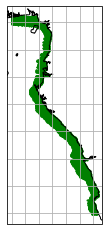

In [8]:
#standard release zone around tenerife
data_path = '/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/' 

#override for wlternative release zones
if second_gen:
    zone_list = ['release_zone_shelf_30N_20N.csv', 'release_zone_shelf_20N_10N.csv', 
        'release_zone_shelf_10N_7E.csv','release_zone_shelf_7E_10S.csv']

    exterior = pd.read_csv(Path(data_path + zone_list[release_zone_nr-1])).values.tolist()
    box_poly = Polygon(exterior, [])

if scale_part_number:
    
    factor_list = [0.25251346443841644, 0.3534648993158345, 0.17045281458435538, 0.2235688216613935] #from area calculations
    number_particles = int(number_particles*factor_list[release_zone_nr-1])
    
#generate lat lon values inside the polygon
in_poly = get_uniform_random_latlon_within_polygon(box_poly,N = number_particles, max_iter=40)

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree()},
    figsize=(4, 4),
)

#ax.plot(box_poly.exterior.xy, transform=cartopy.crs.PlateCarree(), linewidth=1, color="blue")
in_poly.astype(float).plot.scatter(
        x="lon", y="lat", s=1, c="green",
        ax=ax, transform=cartopy.crs.PlateCarree()
        )

ax.coastlines()
ax.gridlines()

In [9]:
#random release time in time window (1st day of release week)
rel_time  = np.sort(
   dt.datetime.fromisocalendar(start_year, start_week,1)
    + dt.timedelta(minutes=dt_in_minutes) * np.random.randint(
        0,
        dt.timedelta(days=release_time_in_days) / dt.timedelta(minutes=dt_in_minutes),
        size=(number_particles, )
    )
)

#calc correct runtime
corr_runtime_in_days = runtime_in_days + release_time_in_days

depth = np.random.uniform(
    depth_min,
    depth_max,
    size=rel_time.shape
)

pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle,
    lat=in_poly.lat.values,
    lon=in_poly.lon.values,
    depth=depth,
    time=rel_time
) 
print(f"Created {len(pset)} particles.")

Created 11178 particles.


In [21]:
#Kernels and error handling
def DeleteParticle(particle, fieldset, time): 
    particle.delete()

recovery_cases = {
    ErrorCode.ErrorOutOfBounds: DeleteParticle
}

custom_kernel = pset.Kernel(AdvectionRK4_3D)

In [22]:
#prepare Output
output_filenamepath = outpath + output_filename
print(output_filenamepath)

outputfile = pset.ParticleFile(
    name=output_filenamepath,
    outputdt=dt.timedelta(hours=outputdt_in_hours)
)

../output_data/second_gen/urchin_2ndgen_zone4_2008_w01_RT-180_N-50000_seed-12345.nc


In [23]:
%%time
#execute
pset.execute(
    custom_kernel,
    runtime=dt.timedelta(days=corr_runtime_in_days),
    dt=dt.timedelta(minutes=dt_in_minutes * timearrow),
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
    output_file=outputfile,
)

outputfile.export()
outputfile.close()

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-729666/libb089b2439948ba5c1372f226f857ea33_0.so
INFO: Temporary output files are stored in ../output_data/second_gen/out-FIAFVODI.
INFO: You can use "parcels_convert_npydir_to_netcdf ../output_data/second_gen/out-FIAFVODI" to convert these to a NetCDF file during the run.
100%|████████████████████████| 15638400.0/15638400.0 [24:48<00:00, 10509.42it/s]


CPU times: user 18min 22s, sys: 4min, total: 22min 23s
Wall time: 25min 35s
